## Урок 2. Кейс 1. Преобразование признаков

### Домашняя работа

#### 1. Прочитайте базу "COVID_19_data" и сделайте модель для сглаженой формы(экспоненциально) по приросту(первые разности) или по прямому ряду для выздоровлений(или заболеваний) с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import scipy.stats as scs
from datetime import date, datetime

In [2]:
covid = pd.read_csv('covid_19_data.csv')

In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 8 columns):
SNo                23481 non-null int64
ObservationDate    23481 non-null object
Province/State     11286 non-null object
Country/Region     23481 non-null object
Last Update        23481 non-null object
Confirmed          23481 non-null float64
Deaths             23481 non-null float64
Recovered          23481 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.4+ MB


In [4]:
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [5]:
covid['Data'] = pd.to_datetime(covid['ObservationDate']).dt.date
covid = covid.groupby(['Data'])['Confirmed','Deaths','Recovered'].sum()
covid.head()

,Confirmed,Deaths,Recovered
Data,,,
2020-01-22,555.0,17.0,28.0
2020-01-23,653.0,18.0,30.0
2020-01-24,941.0,26.0,36.0
2020-01-25,1438.0,42.0,39.0
2020-01-26,2118.0,56.0,52.0


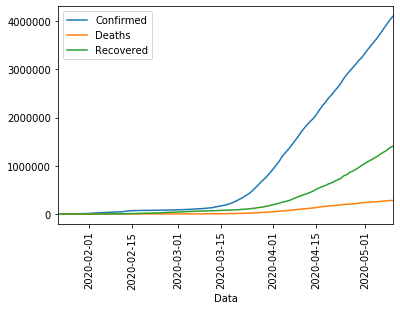

In [6]:
covid.plot()
plt.xticks(label = covid.index.get_level_values('Data'), rotation=90)
plt.show()

Для работы возьмем series "Сonfirmed"   
вычислим значения первых разностей:

In [7]:
d_covid_data = covid['Confirmed'].values[1:]- covid['Confirmed'].values[:-1]

In [8]:
DF_data = sm.tsa.stattools.adfuller(covid['Confirmed'].values,regression='ctt')
DF_data

(-3.4247128632557997,
 0.1331721897688259,
 12,
 97,
 {'1%': -4.494768875917224,
  '5%': -3.8947305593240955,
  '10%': -3.5916200220451353},
 1958.4131490882514)

In [9]:
DF_data_db = sm.tsa.stattools.adfuller(d_covid_data,regression='ctt')
print('коэффициент ADF для 1-й разности для графика COVID: ', DF_data_db[1])

коэффициент ADF для 1-й разности для графика COVID:  0.9658562890714928


значение ненулевое, значит ряд нестационарен (действительно, на графике выражен явный тренд)

построим модель:

In [10]:
b_ar = covid['Confirmed'].values
b_s = pd.DataFrame(data = covid[['Confirmed']])
b_s.head()

,Confirmed
Data,
2020-01-22,555.0
2020-01-23,653.0
2020-01-24,941.0
2020-01-25,1438.0
2020-01-26,2118.0


Text(0.5, 1.0, 'Covid')

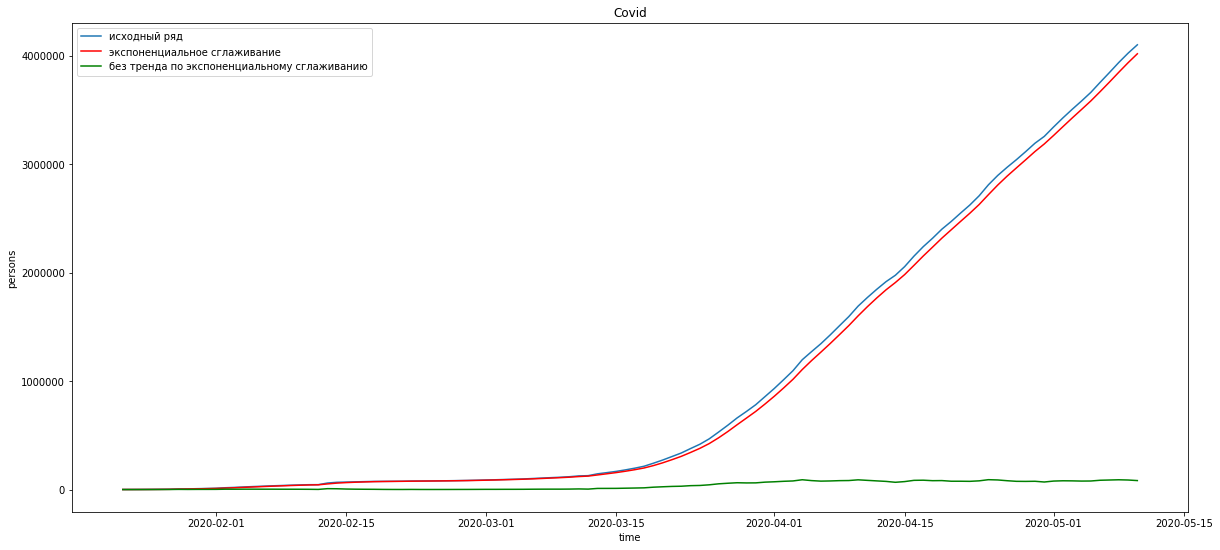

In [11]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

b_ar_exp_1 = exponential_smoothing(covid['Confirmed'], 0.5)

plt.figure(figsize=(20, 9))
plt.plot(b_s.index, b_s['Confirmed'], label='исходный ряд')
plt.plot(b_s.index,b_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(b_s.index,b_s['Confirmed'] - b_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('persons')
plt.legend()
plt.title('Covid')

In [12]:
train = b_s.iloc[:-10, :]
test = b_s.iloc[-10:, :]

b_ar_exp_1 = pd.DataFrame(data = b_ar_exp_1, index = b_s.index)

In [13]:
df= pd.DataFrame(b_ar_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_1'] = exponential_smoothing(df[0], 0.1)
df['exp_0_3'] = exponential_smoothing(df[0], 0.3)
df['exp_0_5'] = exponential_smoothing(df[0], 0.5)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]


df.head()

C:\Users\sd\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,0,t,t1,t2,exp_0_1,exp_0_3,exp_0_5,diff1
Data,,,,,,,,
2020-01-22,555.000,0.00,0.0,0.0,555.0000,555.0000,555.000,0.0
2020-01-23,604.000,555.00,0.0,0.0,559.9000,569.7000,579.500,0.0
2020-01-24,772.500,604.00,555.0,0.0,581.1600,630.5400,676.000,0.0
2020-01-25,1105.250,772.50,604.0,555.0,633.5690,772.9530,890.625,0.0
2020-01-26,1611.625,1105.25,772.5,604.0,731.3746,1024.5546,1251.125,0.0


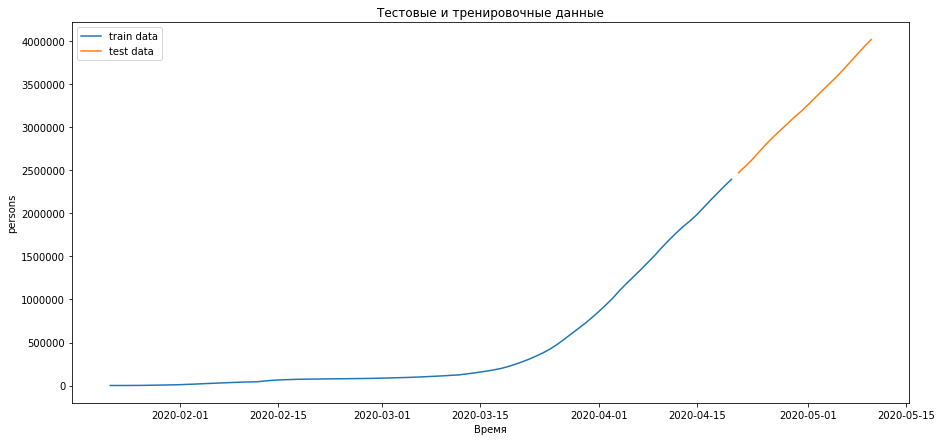

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Data') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Data') >  split_date].copy()

train_b, test_b = split_data_b( df, datetime.strptime('20-04-2020', '%d-%m-%Y').date())



X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('persons')
plt.plot(train_b.index.get_level_values('Data'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Data'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

#### 2. Оцените ошибку модели из п.1 .

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

ошибка градиентного бустинга :   25.542071220629943 %


#### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [16]:
h=5
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

ошибка градиентного бустинга :   29.58762263302766 %


In [17]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

ошибка градиентного бустинга :   33.823209655809784 %


Видим, что с увеличением глубины  прогноза ошибка увеличивается 

#### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):



а) Изменение температуры за окном :).   
на большом промежутке времени - стационарный, в пределах года - нестационарный, с сезоном

б) Количество денег, которые тратят покупатели в интернет магазине.   
нестационарный, с сезоном (праздники)

в) Вес растущего котенка.   
нестационарный, с трендом

г) Прирост объема деревьев в лесу от времени  
поскольку лес - замкнутая экосистема, и количество деревьев регулируется само (исключая внешние факторы, пожары, наводнения), то ряд - стационарный